In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn

import matplotlib.pyplot as plt

In [149]:
# Generate training data. We use a compound lookup table, then add some noise.
data = pd.read_csv("train_data.csv")
training_size = 1000

# Select a bunch of random rows in the data
np.random.seed(2)
masses = []
species = []
for i in range(training_size):
    rand_index = np.random.randint(10)
    masses.append(data.at[rand_index, "Precise Mass"])
    # Use one-hot encodig of species strings to integers.
    species.append(rand_index)
masses = np.array(masses)

# Generate noise for the same number of rows'
noise = 0.01 * np.random.standard_normal(size = training_size)

# Combine the noise and randomly selected masses to create our training data
x_data = masses + noise
y_data = species
# print("x_data: ", x_data)
# print("y_data: ", y_data)

In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# TODO Scale data if needed?
# Normalize data before we pass it through our network.
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train.reshape(-1,1))
# y_train = scaler.fit_transform(y_train.reshape(-1,1))

# 72 / 18 / 10 train / validation / test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1)

x_validation = x_train[int(0.8*len(x_train)):]
x_train = x_train[:int(0.8*len(x_train))]
y_validation = y_train[int(0.8*len(y_train)):]
y_train = y_train[:int(0.8*len(y_train))]

x_train = np.reshape(x_train, (len(x_train),1))
x_validation = np.reshape(x_validation, (len(x_validation),1))
x_test = np.reshape(x_test, (len(x_test),1))
y_train = np.array(y_train)
y_validation = np.array(y_validation)
y_test = np.array(y_test)

print(len(x_train))
print(len(x_validation))
print(len(x_test))
print(len(y_train))
print(len(y_validation))
print(len(y_test))

720
180
100
720
180
100


In [169]:
# Define our model
class speciesClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim):
        
        super(speciesClassification, self).__init__()
        
        # Create input layer, 2 hidden layers of 32 neurons each with ReLu activation functions after each layer, and
        # output layer
        self.layer1 = nn.Linear(input_dim, 32)
        self.actfun1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 32)
        self.actfun2 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        # Send our inputs through the network defined above
        x = self.layer1(x)
        x = self.actfun1(x)
        x = self.layer2(x)
        x = self.actfun2(x)
        x = self.output_layer(x)
        out = self.softmax(x)
        
        return out

In [170]:
# Initialize our neural network model with input and output dimensions
# Input: A single float representing the atomic weight
# Ouput: A vector of 10 entries representing the probability our input species is one of the corresponding 
#        10 output classes
model = speciesClassification(1, 10)

# Define the learning rate and epoch 
learning_rate = 0.01
epochs = 1000
batchsize = 50

# Define loss function and optimizer. Start out using SGD (TODO: CHANGE LATER IF NEEDED).
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

model

speciesClassification(
  (layer1): Linear(in_features=1, out_features=32, bias=True)
  (actfun1): ReLU()
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (actfun2): ReLU()
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [171]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = []

In [ ]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

# YOUR CODE HERE
x_train_final = torch.from_numpy(x_train).float()
y_train_final = torch.from_numpy(y_train).long()

x_validation_final = torch.from_numpy(x_validation).float()
y_validation_final = torch.from_numpy(y_validation).long()

x_test_final = torch.from_numpy(x_test).float()
y_test_final = torch.from_numpy(y_test).long()

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    # YOUR CODE HERE
    # Step through the optimizer and update the loss on each step.
    optimizer.zero_grad()
    outputs = model(x_train_final)

    # print(outputs.shape)
    # print(y_train_final.shape)
    
    loss = loss_func(outputs, y_train_final)
    train_loss_list.append(loss.item())
    loss.backward()
    optimizer.step()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    
    # YOUR CODE HERE
    with torch.no_grad(): # Tell PyTorch that we aren't passing inputs to network for training purpose
        
        # Pass the validation feature data (30 samples) to the network
        validation_outputs = model(x_validation_final)
        
        # validation_outputs = tensor of shape (30, 3), i.e., 30 predictions and each prediction has 3 probabilities.
        # These are classification probabilities for each flower type: [p(setosa), p(versicolor), p(virginica)].
        # torch.argmax(validation_outputs, dim=1) finds the index with the maximum value alongside the column direction
        # i.e. for each sample, it finds the column index with the highest probability.
        # == validation_targets compares these indices with groundtruth validation target labels for each sample
        # For each sample, it returns True if the index matches the target, False otherwise
        # .type(torch.FloatTensor) converts True = 1, False = 0
        # Finally .mean() gives us (Total count of 1) / (Length of the 1D tensor), giving us the classification accuracy  
        
        correct = (torch.argmax(validation_outputs, dim=1) == 
                   y_validation_final).type(torch.FloatTensor)
        
        validation_accuracy_list.append(correct.mean())

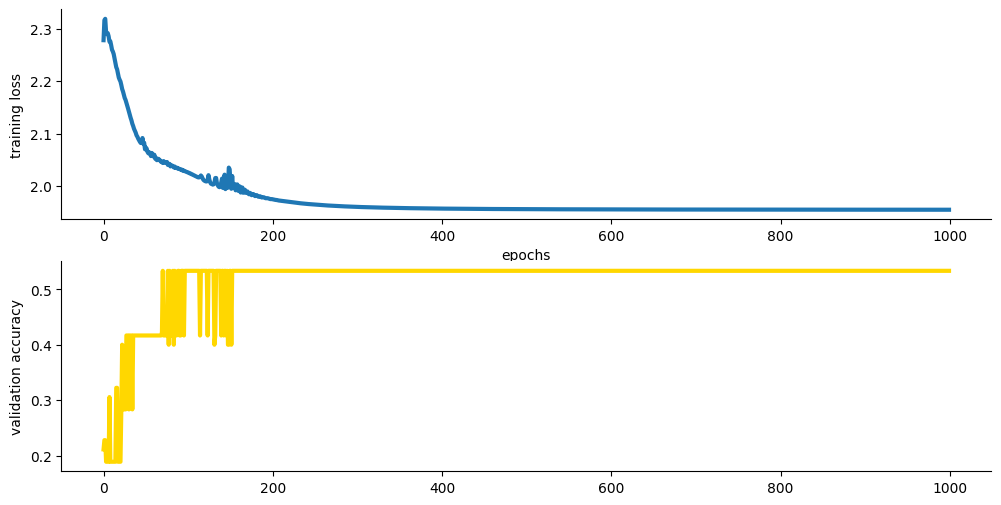

In [174]:
# Import seaborn for prettier plots

import seaborn as sns
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [175]:
# YOUR CODE HERE
# Compute the testing accuracy.
with torch.no_grad(): # Tell PyTorch that we aren't passing inputs to network for training purpose.

    # Pass the testing feature data to the network to produce model predictions.
    y_pred_test = model(x_test_final) 
    
    # Use the same technique as above to compute the testing classification accuracy.
    correct = (torch.argmax(y_pred_test, dim=1) == y_test_final).type(torch.FloatTensor)
    
    # Print test accuracy to the user.
    print("Testing Accuracy: " + str(correct.mean().numpy()*100) + '%')

Testing Accuracy: 52.99999713897705%


In [176]:
# Check dimensions of our prediction and actual arrays and print some useful things.
print(torch.argmax(y_pred_test, dim=1))
print(x_test_final.numpy().shape)
print(y_pred_test.numpy().shape)
print(correct.numpy().shape)

tensor([3, 6, 0, 6, 2, 6, 6, 6, 1, 6, 6, 6, 0, 3, 6, 1, 6, 0, 6, 6, 0, 6, 6, 6,
        3, 6, 1, 0, 2, 0, 0, 2, 6, 6, 2, 0, 3, 0, 6, 1, 2, 6, 3, 6, 1, 2, 6, 2,
        1, 0, 6, 2, 6, 2, 3, 6, 1, 6, 0, 6, 3, 6, 3, 6, 3, 6, 3, 2, 6, 6, 1, 1,
        6, 6, 0, 2, 6, 6, 2, 6, 6, 6, 3, 3, 6, 0, 6, 1, 1, 6, 0, 6, 2, 6, 3, 6,
        3, 2, 6, 6])
(100, 1)
(100, 10)
(100,)
